In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


2025-06-22 05:56:55.250700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750571815.466977      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750571815.529837      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os

# Define the folder path
audio_folder = "../input/audio-file/AUDIO file"

# List all files inside it
print(" Files inside AUDIO file folder:")
for root, dirs, files in os.walk(audio_folder):
    for file in files:
        print(os.path.join(root, file))






 Files inside AUDIO file folder:
../input/audio-file/AUDIO file/Audio_Song_Actors_01-24/Actor_02/03-02-05-02-01-01-02.wav
../input/audio-file/AUDIO file/Audio_Song_Actors_01-24/Actor_02/03-02-06-01-02-02-02.wav
../input/audio-file/AUDIO file/Audio_Song_Actors_01-24/Actor_02/03-02-03-02-01-02-02.wav
../input/audio-file/AUDIO file/Audio_Song_Actors_01-24/Actor_02/03-02-03-01-02-02-02.wav
../input/audio-file/AUDIO file/Audio_Song_Actors_01-24/Actor_02/03-02-04-02-01-01-02.wav
../input/audio-file/AUDIO file/Audio_Song_Actors_01-24/Actor_02/03-02-01-01-01-01-02.wav
../input/audio-file/AUDIO file/Audio_Song_Actors_01-24/Actor_02/03-02-01-01-02-02-02.wav
../input/audio-file/AUDIO file/Audio_Song_Actors_01-24/Actor_02/03-02-04-01-01-01-02.wav
../input/audio-file/AUDIO file/Audio_Song_Actors_01-24/Actor_02/03-02-04-02-02-02-02.wav
../input/audio-file/AUDIO file/Audio_Song_Actors_01-24/Actor_02/03-02-06-02-01-01-02.wav
../input/audio-file/AUDIO file/Audio_Song_Actors_01-24/Actor_02/03-02-06-02-0

In [3]:
import pandas as pd
import os

# Set the correct Kaggle paths (adjusted from your structure)
base_path = "../input/audio-file/AUDIO file"
song_path = os.path.join(base_path, "Audio_Song_Actors_01-24")
speech_path = os.path.join(base_path, "Audio_Speech_Actors_01-24")  # Only if exists

# Emotion code mapping based on RAVDESS filename
emotion_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fear",
    "07": "disgust",
    "08": "surprise"
}

# Function to extract emotion labels and paths from directory
def extract_ravdess_data(directory, modality_type="Speech"):
    file_emotion = []
    file_path = []

    if not os.path.exists(directory):
        print(f" Directory not found: {directory}")
        return pd.DataFrame(columns=['Emotion', 'Path', 'Modality'])

    actor_folders = sorted(os.listdir(directory))
    for actor in actor_folders:
        actor_dir = os.path.join(directory, actor)
        if os.path.isdir(actor_dir):
            for file in os.listdir(actor_dir):
                if file.endswith(".wav"):
                    part = file.split('.')[0].split('-')
                    if len(part) >= 3:
                        emotion_code = part[2]
                        emotion = emotion_map.get(emotion_code, "Unknown")
                        file_emotion.append(emotion)
                        file_path.append(os.path.join(actor_dir, file))

    df = pd.DataFrame({'Emotion': file_emotion, 'Path': file_path, 'Modality': modality_type})
    return df

# Extract from song and (if available) speech folders
song_df = extract_ravdess_data(song_path, modality_type="Song")
speech_df = extract_ravdess_data(speech_path, modality_type="Speech")

# Combine them
combined_df = pd.concat([speech_df, song_df], ignore_index=True)

# Optional: save to CSV
combined_df.to_csv("ravdess_combined.csv", index=False)

# Show sample
combined_df.head()


,Emotion,Path,Modality
0,calm,../input/audio-file/AUDIO file/Audio_Speech_Ac...,Speech
1,neutral,../input/audio-file/AUDIO file/Audio_Speech_Ac...,Speech
2,sad,../input/audio-file/AUDIO file/Audio_Speech_Ac...,Speech
3,calm,../input/audio-file/AUDIO file/Audio_Speech_Ac...,Speech
4,calm,../input/audio-file/AUDIO file/Audio_Speech_Ac...,Speech


# DATA VISUALISATION AND EXPLORATION

### Emotions Count Plot

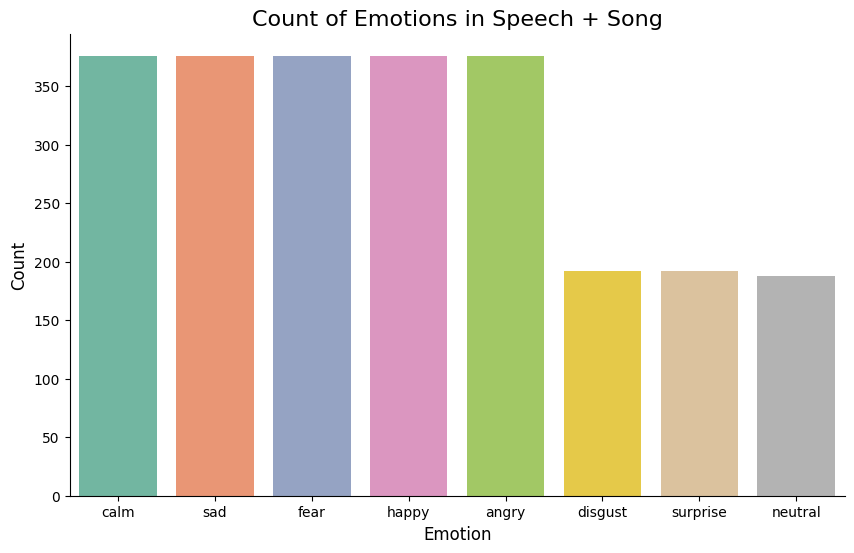

In [4]:
plt.figure(figsize=(10, 6))
plt.title('Count of Emotions in Speech + Song', fontsize=16)
sns.countplot(data=combined_df, x='Emotion', order=combined_df['Emotion'].value_counts().index, palette="Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Emotion', fontsize=12)
sns.despine(top=True, right=True)
plt.show()


### Waveplot and Spectrogram Functions

 Emotions found: ['calm' 'neutral' 'sad' 'fear' 'happy' 'disgust' 'angry' 'surprise']

 Showing plots for emotion: calm


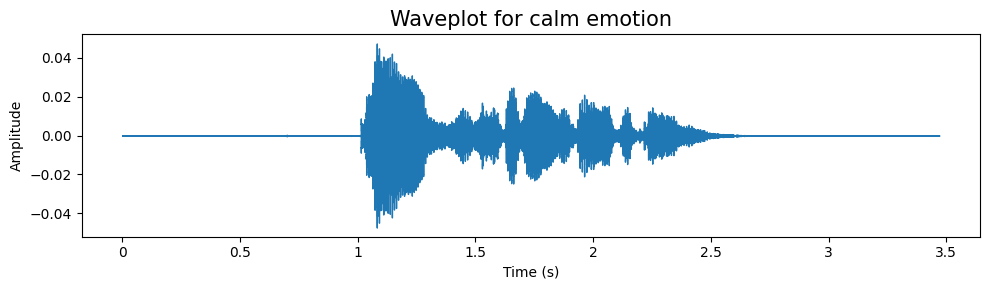

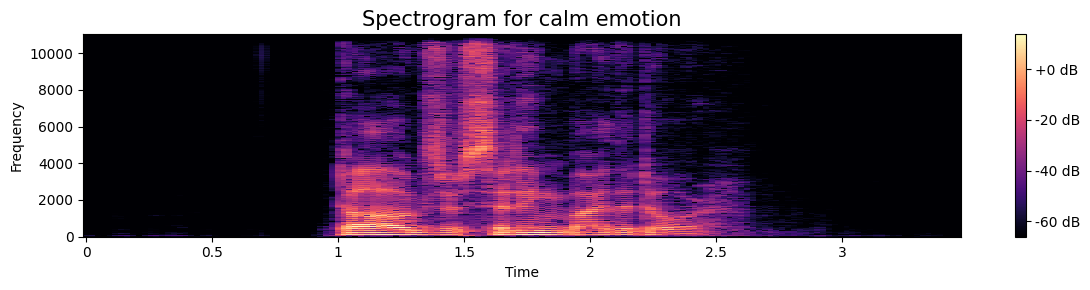


 Showing plots for emotion: neutral


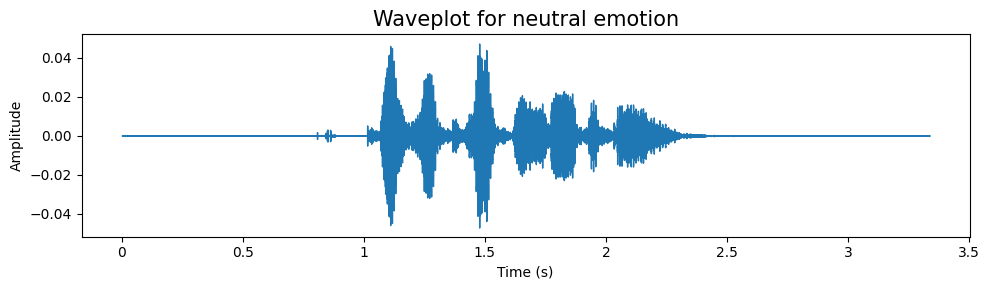

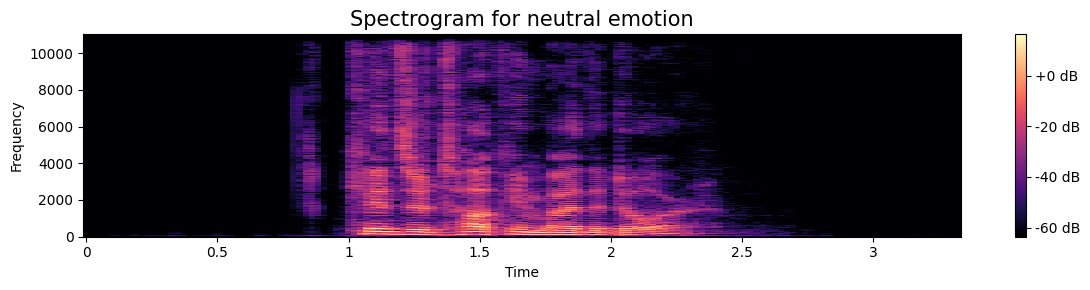


 Showing plots for emotion: sad


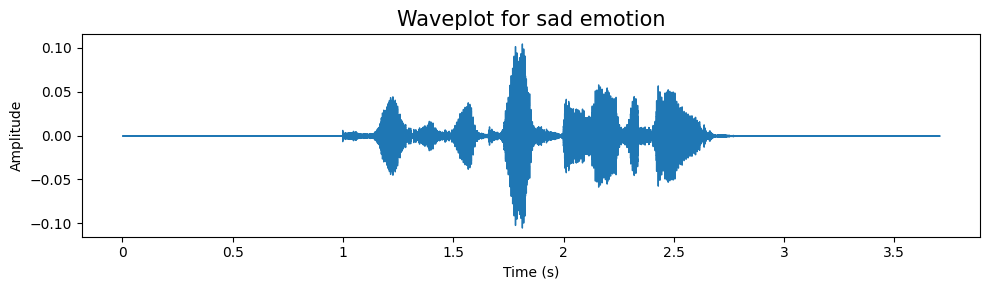

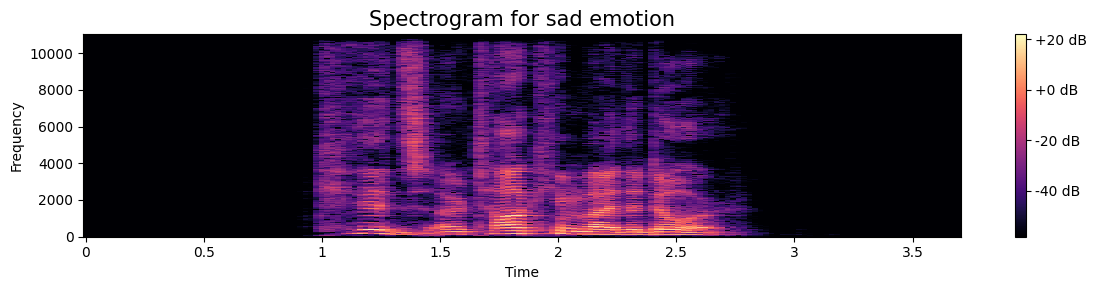


 Showing plots for emotion: fear


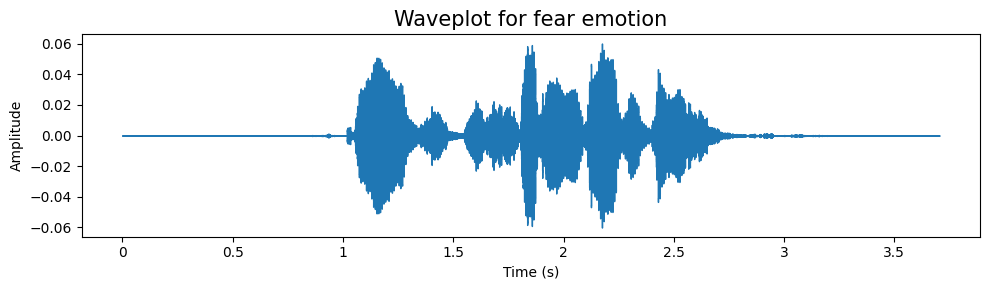

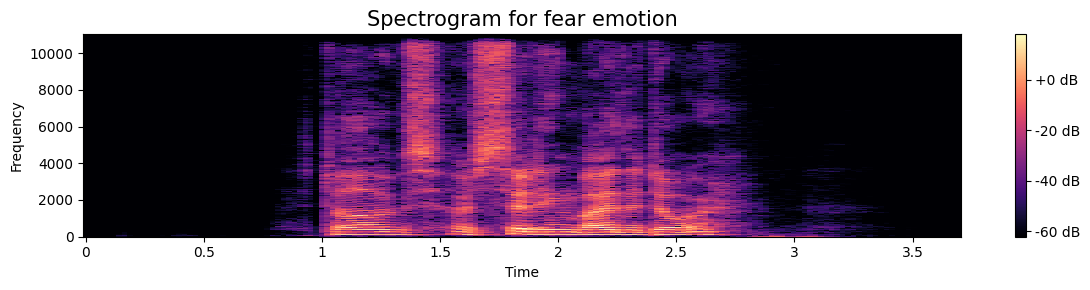


 Showing plots for emotion: happy


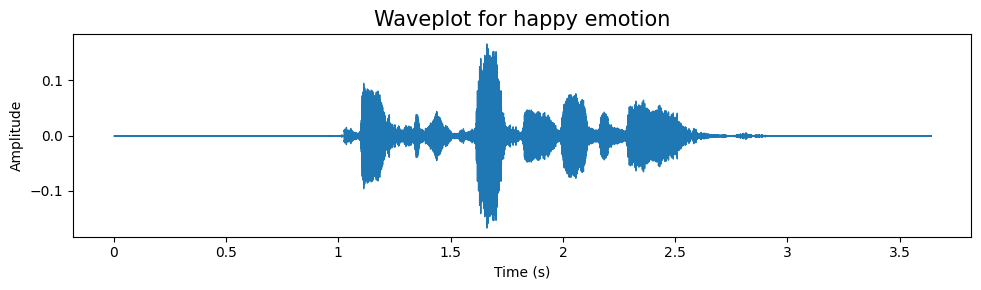

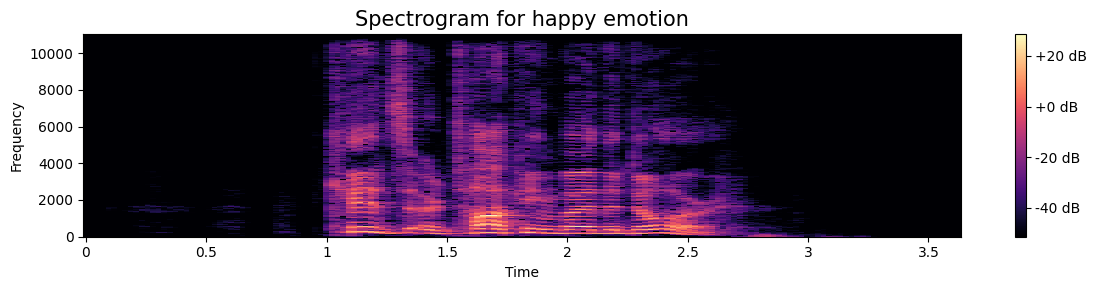


 Showing plots for emotion: disgust


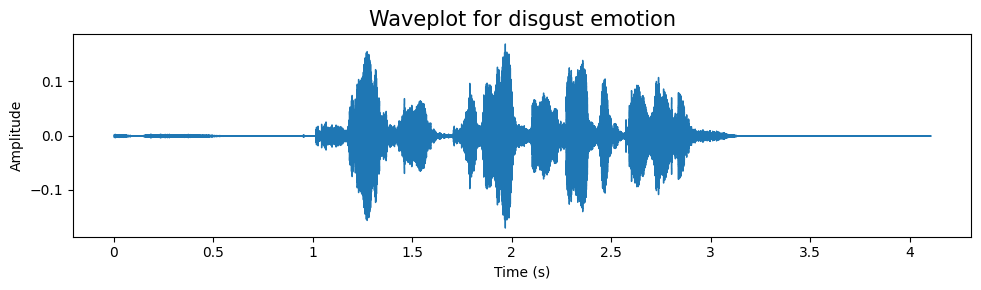

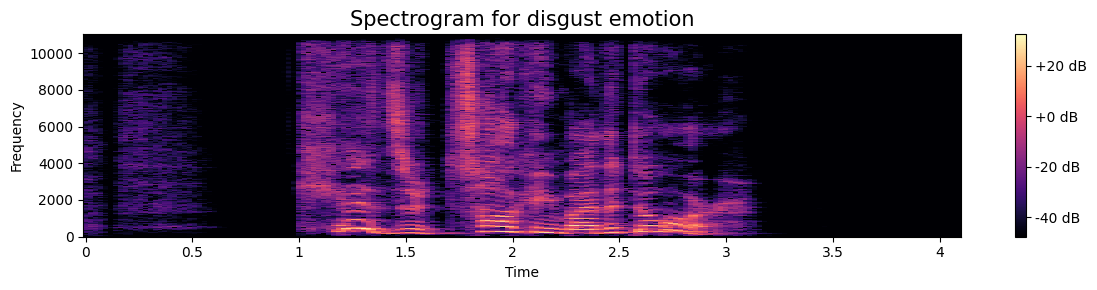


 Showing plots for emotion: angry


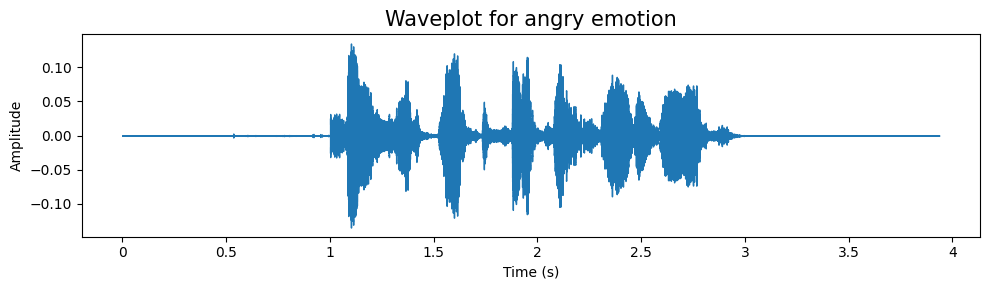

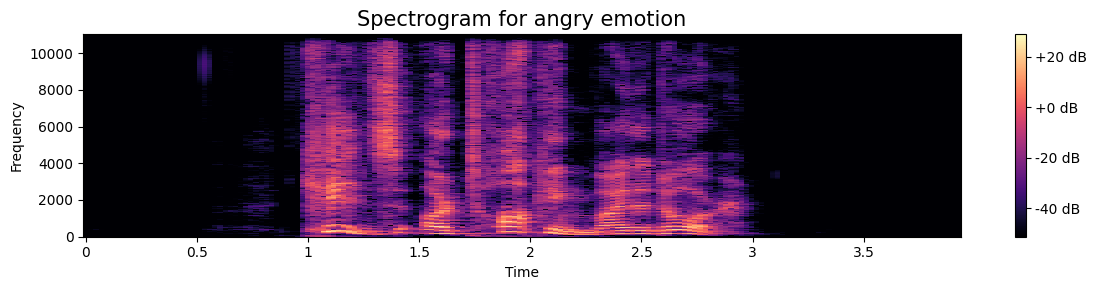


 Showing plots for emotion: surprise


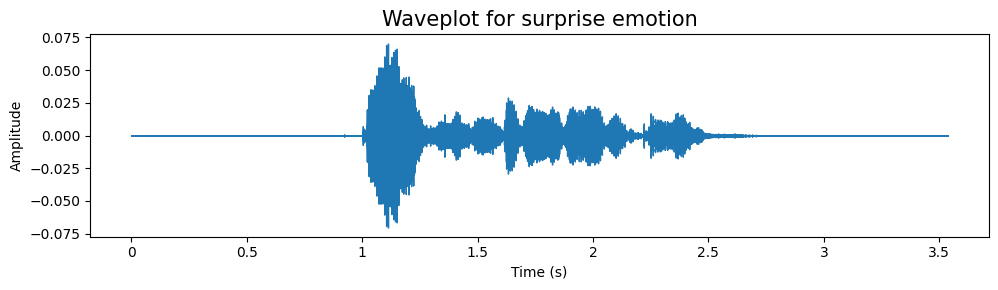

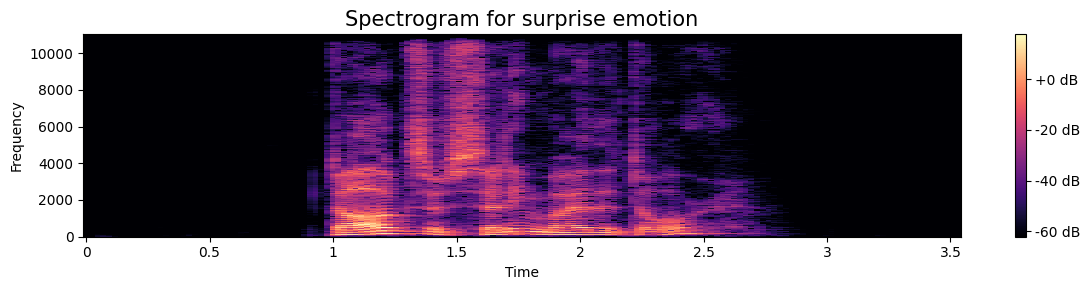

In [5]:
# Ensure ffmpeg is installed for non-wav files
# You can install with: !apt install ffmpeg -y  (in Colab)
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Function to create a waveplot from combined_df row
def create_waveplot_from_df_row(row):
    path = row['Path']
    emotion = row['Emotion']
    try:
        y, sr = librosa.load(path)
        if y is not None and len(y) > 0:
            plt.figure(figsize=(10, 3))
            plt.title(f'Waveplot for {emotion} emotion', size=15)
            librosa.display.waveshow(y, sr=sr)
            plt.xlabel("Time (s)")
            plt.ylabel("Amplitude")
            plt.tight_layout()
            plt.show()
        else:
            print(f" Failed to load or empty audio: {path}")
    except Exception as e:
        print(f" Error loading file {path}: {e}")

#  Function to create a spectrogram from combined_df row
def create_spectrogram_from_df_row(row):
    path = row['Path']
    emotion = row['Emotion']
    try:
        y, sr = librosa.load(path)
        X = librosa.stft(y)
        Xdb = librosa.amplitude_to_db(abs(X))
        plt.figure(figsize=(12, 3))
        plt.title(f'Spectrogram for {emotion} emotion', size=15)
        librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
        plt.colorbar(format='%+2.0f dB')
        plt.xlabel('Time')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f" Error generating spectrogram for {path}: {e}")

# Get one row per emotion
unique_emotions = combined_df['Emotion'].unique()

print(" Emotions found:", unique_emotions)

for emotion in unique_emotions:
    # Filter the first example for this emotion
    sample_row = combined_df[combined_df['Emotion'] == emotion].iloc[0]
    
    print(f"\n Showing plots for emotion: {emotion}")
    
    create_waveplot_from_df_row(sample_row)
    create_spectrogram_from_df_row(sample_row)



###  Above we Visualized Audio with Waveplots & Spectrograms
###  Plotted waveforms (amplitude vs. time)

###  Plotted spectrograms (frequency vs. time)
  
###  All these helps in :
  
###  1. Understand differences between emotions: e.g., happy sounds might be louder and faster than         sad ones.

###  2. Helps you verify audio quality, check for noise, silence, or corruption.

###  3. Spectrograms give a visual fingerprint of how emotions vary in pitch and energy.

###  4. Useful for data exploration, debugging, and presentations.

# DATA AUGMENTATION

### Applying data augmentation techniques on your audio data to:
### 1. Increase the diversity of training samples
### 2. Help your model generalize better to new voices, accents, noise, etc.
### 3. Reduce overfitting

 Original Audio


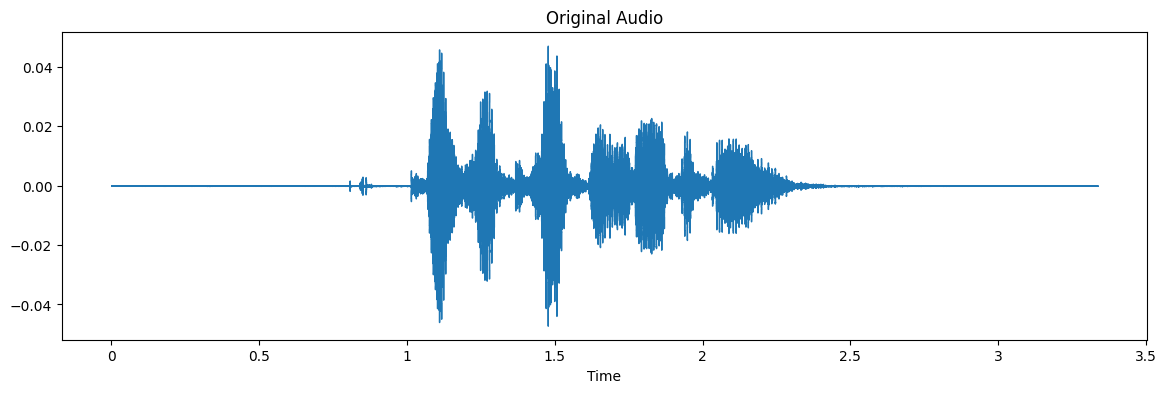

 Noise Injected


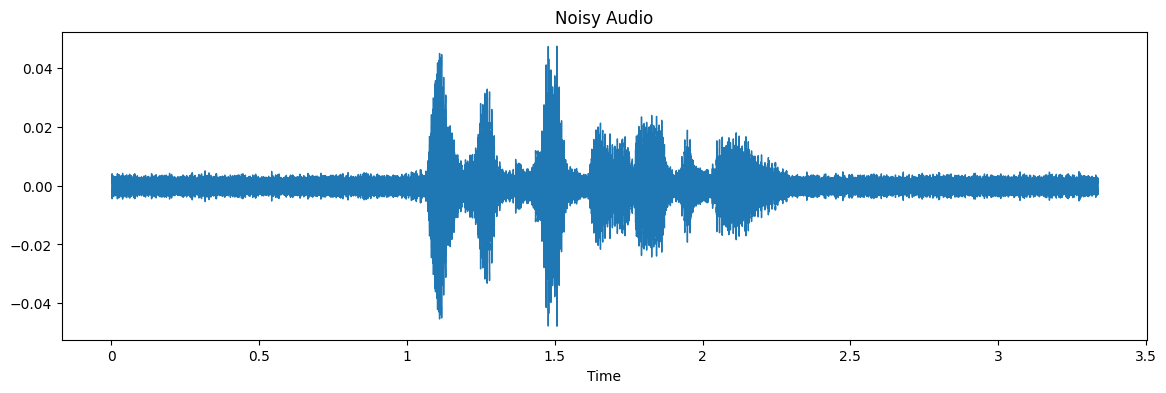

 Time Shifted


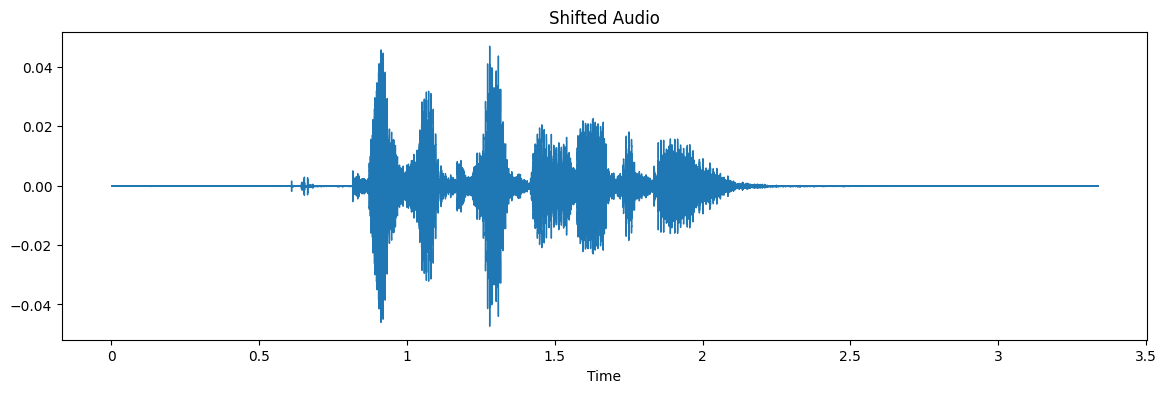

 Pitch Increased


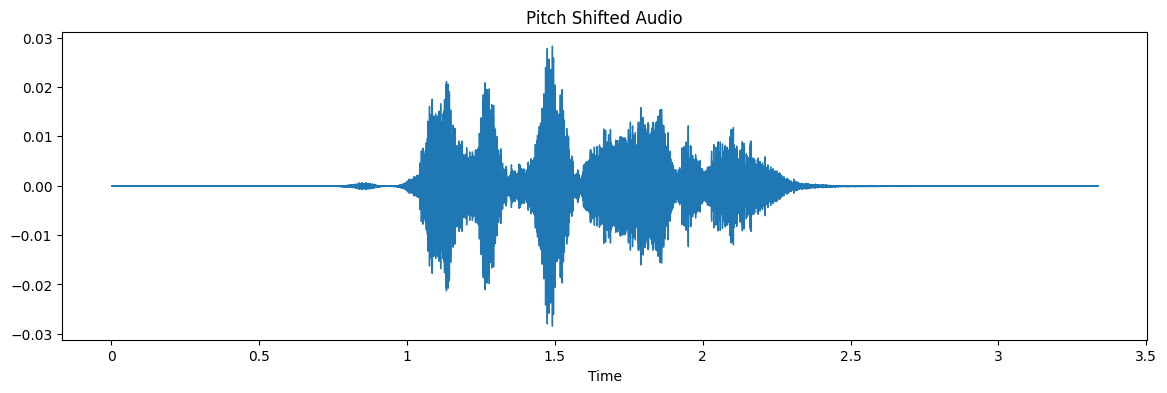

In [6]:
# Ensure ffmpeg is installed for non-wav files
# You can install with: !apt install ffmpeg -y  (in Colab)
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

# Augmentation functions

def add_noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    return data + noise_amp * np.random.normal(size=data.shape[0])

def shift_audio(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def change_pitch(data, sr, n_steps=4):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=n_steps)

# Load sample audio
sample_row = combined_df.iloc[1]
path = sample_row['Path']
emotion = sample_row['Emotion']
data, sr = librosa.load(path)

# 1. Original
print(" Original Audio")
plt.figure(figsize=(14, 4))
librosa.display.waveshow(data, sr=sr)
plt.title("Original Audio")
plt.show()
display(Audio(data, rate=sr))

# 2. Add Noise
noised = add_noise(data)
print(" Noise Injected")
plt.figure(figsize=(14, 4))
librosa.display.waveshow(noised, sr=sr)
plt.title("Noisy Audio")
plt.show()
display(Audio(noised, rate=sr))

# 3. Shift
shifted = shift_audio(data)
print(" Time Shifted")
plt.figure(figsize=(14, 4))
librosa.display.waveshow(shifted, sr=sr)
plt.title("Shifted Audio")
plt.show()
display(Audio(shifted, rate=sr))

# 4. Pitch Changed
pitched = change_pitch(data, sr, n_steps=4)
print(" Pitch Increased")
plt.figure(figsize=(14, 4))
librosa.display.waveshow(pitched, sr=sr)
plt.title("Pitch Shifted Audio")
plt.show()
display(Audio(pitched, rate=sr))


# Feature Extraction

### Raw audio is just a waveform — a series of numbers over time. Machine learning models don’t understand waveforms well directly. Instead, we extract features that capture meaningful audio patterns.

In [7]:
# Ensure ffmpeg is installed for non-wav files
# You can install with: !apt install ffmpeg -y  (in Colab)
import numpy as np
import pandas as pd
import librosa

#  Updated Feature Extraction Function with Additional Features 
def extract_features(data, sample_rate):
    result = np.array([])

    # Trim silence
    data, _ = librosa.effects.trim(data)

    # Zero Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))

    # STFT
    stft = np.abs(librosa.stft(data))

    # Chroma STFT
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC (40 Coefficients)
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)
    result = np.hstack((result, mfcc))

    # RMS Energy
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # Mel Spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))

    # Spectral Centroid
    centroid = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, centroid))

    # Spectral Bandwidth
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, bandwidth))

    # Spectral Contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, contrast))

    # Tonnetz
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(data), sr=sample_rate).T, axis=0)
    result = np.hstack((result, tonnetz))

    return result

#  Augmentation Wrappers 
def add_noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    return data + noise_amp * np.random.normal(size=data.shape[0])

def shift_audio(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def change_pitch(data, sr, n_steps=4):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=n_steps)

#  Full Feature Wrapper with Augmentations 
def get_features(path):
    data, sr = librosa.load(path, duration=2.5, offset=0.6)
    features = []

    # Original
    features.append(extract_features(data, sr))

    # Add noise
    features.append(extract_features(add_noise(data), sr))

    # Shifted audio
    features.append(extract_features(shift_audio(data), sr))

    # Pitch-shifted audio
    features.append(extract_features(change_pitch(data, sr), sr))

    return features

#  Main Loop Over Dataset 
X, Y = [], []

for idx, row in combined_df.iterrows():
    emotion = row['Emotion']
    path = row['Path']
    try:
        feats = get_features(path)
        for f in feats:
            X.append(f)
            Y.append(emotion)
    except Exception as e:
        print(f" Error processing {path}: {e}")

#  Save Extracted Features 
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('ravdess_features.csv', index=False)
print(" Feature extraction complete. Saved to ravdess_features.csv")

#  Optional: Preview 
Features.head()


 Feature extraction complete. Saved to ravdess_features.csv


,0,1,2,3,4,5,6,7,8,9,...,188,189,190,191,192,193,194,195,196,labels
0,0.236738,0.581064,0.644821,0.669962,0.690636,0.652294,0.588105,0.593542,0.622836,0.675449,...,16.817328,17.753885,45.577728,-0.038361,-0.045984,-0.081246,-0.078981,-0.004993,0.030707,calm
1,0.307414,0.734257,0.771656,0.798405,0.807974,0.776285,0.657600,0.633479,0.678890,0.753631,...,14.768347,14.137311,13.565149,-0.013984,-0.038537,-0.074117,-0.017762,-0.013645,0.022594,calm
2,0.277213,0.606876,0.656334,0.691501,0.707835,0.685175,0.617906,0.600995,0.635912,0.679775,...,16.786235,17.274924,44.290272,-0.033070,-0.035189,-0.108866,-0.022323,-0.023711,0.026405,calm
3,0.161164,0.720495,0.731634,0.714585,0.626030,0.608031,0.634510,0.634819,0.634612,0.615162,...,18.521485,19.834491,48.380975,-0.024261,0.020987,-0.094886,-0.076345,0.030136,-0.020177,calm
4,0.202796,0.653347,0.691123,0.655023,0.623678,0.640620,0.624523,0.617340,0.670686,0.696123,...,16.396313,19.067399,45.106221,-0.054769,0.012871,-0.133923,-0.038059,0.016469,-0.006946,neutral


# Split into train and validation dataset

In [8]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#  Load Extracted Features 
features = pd.read_csv("ravdess_features.csv")

#  Split into Features and Labels 
X = features.drop(columns=["labels"]).values
Y = features["labels"].values

#  One-Hot Encode the Labels 
encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.reshape(-1, 1)).toarray()

#  Perform 80/20 Train-Validation Split 
x_train, x_val, y_train, y_val = train_test_split(
    X, Y, test_size=0.20, random_state=42, shuffle=True
)

#  Standardize Features 
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

#  Reshape for CNN (3D format) 
x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)

#  Print Shapes 
print(" Train-Validation Split Complete")
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)



 Train-Validation Split Complete
x_train shape: (7846, 197, 1)
y_train shape: (7846, 8)
x_val shape: (1962, 197, 1)
y_val shape: (1962, 8)


In [9]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Convert one-hot y_train back to label strings using encoder
y_train_labels = encoder.inverse_transform(y_train).flatten()

# Compute class weights using the original labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

# Create dictionary in correct format for model.fit
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Print the class weights
print(" Class weights (to handle imbalance):")
for i, cls in enumerate(encoder.categories_[0]):
    print(f"{cls}: {class_weights_dict[i]:.2f}")


 Class weights (to handle imbalance):
angry: 0.81
calm: 0.83
disgust: 1.60
fear: 0.80
happy: 0.81
neutral: 1.62
sad: 0.81
surprise: 1.68


# MODELING

### USING CNN MODEL 

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define model
model = Sequential()

# Conv Block 1
model.add(Conv1D(256, kernel_size=5, activation='relu', padding='same', input_shape=(x_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Conv Block 2
model.add(Conv1D(256, kernel_size=5, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Conv Block 3
model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Conv Block 4
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Conv Block 5
model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# BiLSTM Layer
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.4))

# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(8, activation='softmax'))  # 8 emotion classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


    


2025-06-22 06:47:41.006560: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 197, 256)            │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 197, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 98, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 98, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 98, 256)             │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 98, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 49, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 49, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 49, 128)             │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 49, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 24, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 12, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 12, 32)              │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 12, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 6, 32)               │              

 Total params: 536,616 (2.05 MB)

 Trainable params: 535,144 (2.04 MB)

 Non-trainable params: 1,472 (5.75 KB)

# Train the Model

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callback to save only the best model based on validation loss
checkpoint = ModelCheckpoint(
    filepath='models/model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Early stopping to prevent overfitting
earlystop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate if validation loss plateaus
lr_reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Train the model with class weights
history = model.fit(
    x_train, y_train,
    batch_size=32,            # You can experiment with 32 as well
    epochs=100,
    validation_data=(x_val, y_val),
    class_weight=class_weights_dict,  #  Ensure this is defined correctly
    callbacks=[checkpoint, earlystop, lr_reduce],
    verbose=1
)


Epoch 1/100
245/246 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.1934 - loss: 1.9832
Epoch 1: val_loss improved from inf to 2.02154, saving model to models/model.h5
246/246 ━━━━━━━━━━━━━━━━━━━━ 51s 162ms/step - accuracy: 0.1937 - loss: 1.9825 - val_accuracy: 0.1575 - val_loss: 2.0215 - learning_rate: 0.0010
Epoch 2/100
245/246 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.2561 - loss: 1.7640
Epoch 2: val_loss improved from 2.02154 to 1.80231, saving model to models/model.h5
246/246 ━━━━━━━━━━━━━━━━━━━━ 38s 152ms/step - accuracy: 0.2561 - loss: 1.7639 - val_accuracy: 0.3033 - val_loss: 1.8023 - learning_rate: 0.0010
Epoch 3/100
245/246 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.2900 - loss: 1.6934
Epoch 3: val_loss improved from 1.80231 to 1.71385, saving model to models/model.h5
246/246 ━━━━━━━━━━━━━━━━━━━━ 37s 151ms/step - accuracy: 0.2901 - loss: 1.6931 - val_accuracy: 0.3512 - val_loss: 1.7138 - learning_rate: 0.0010
Epoch 4/100
245/246 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/ste

# Plot Accuracy and Loss

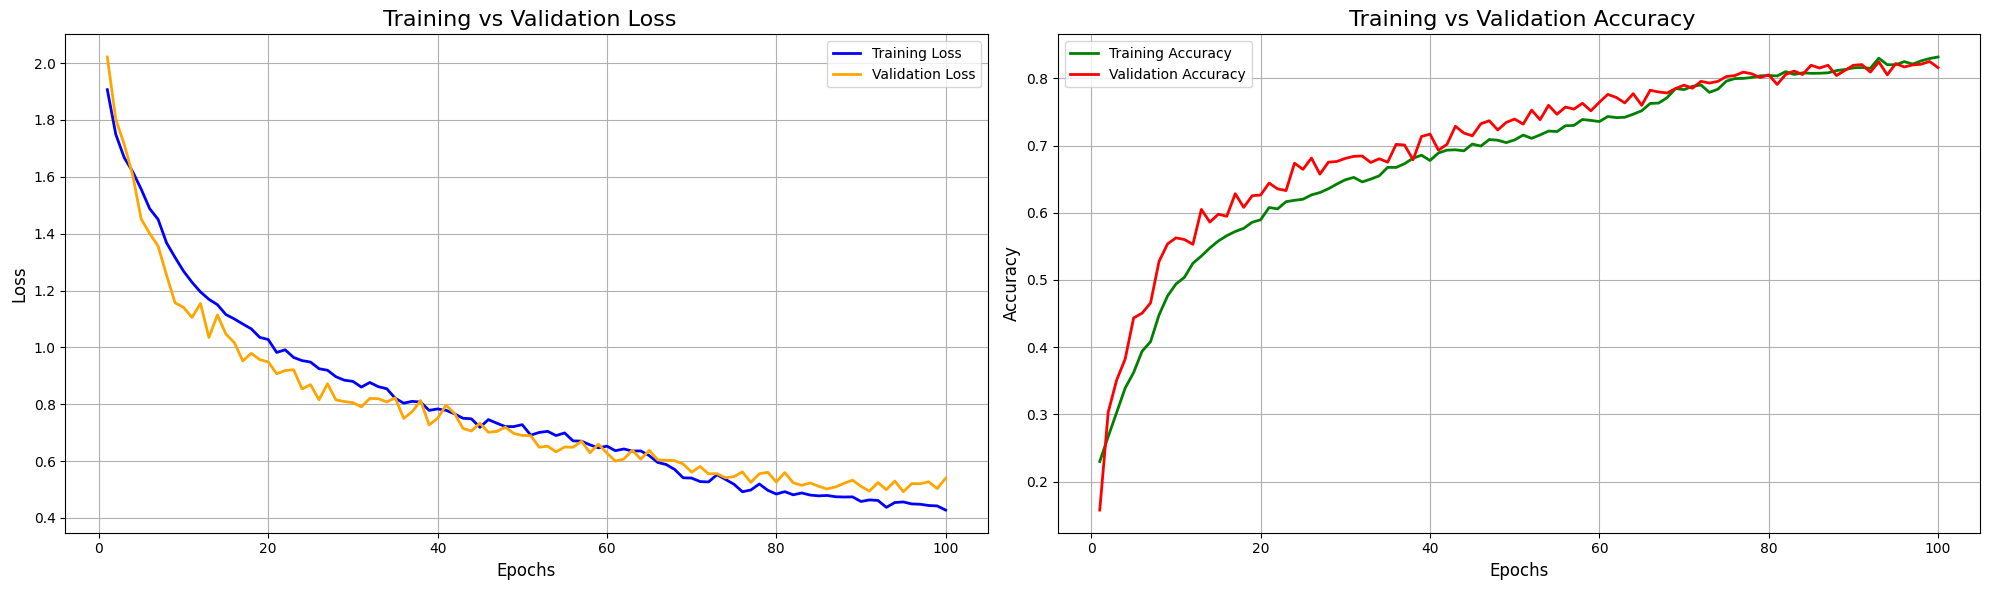

In [12]:


# Dynamically set number of epochs based on training history
epochs = range(1, len(history.history['accuracy']) + 1)

# Extract metrics
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot setup
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# Plot: Training vs Validation Loss 
ax[0].plot(epochs, train_loss, label='Training Loss', color='blue', linewidth=2)
ax[0].plot(epochs, val_loss, label='Validation Loss', color='orange', linewidth=2)
ax[0].set_title(" Training vs Validation Loss", fontsize=16)
ax[0].set_xlabel("Epochs", fontsize=12)
ax[0].set_ylabel("Loss", fontsize=12)
ax[0].grid(True)
ax[0].legend()

#  Plot: Training vs Validation Accuracy 
ax[1].plot(epochs, train_acc, label='Training Accuracy', color='green', linewidth=2)
ax[1].plot(epochs, val_acc, label='Validation Accuracy', color='red', linewidth=2)
ax[1].set_title(" Training vs Validation Accuracy", fontsize=16)
ax[1].set_xlabel("Epochs", fontsize=12)
ax[1].set_ylabel("Accuracy", fontsize=12)
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()


# Evaluation

In [13]:
#  Predict on validation data
pred_val = model.predict(x_val)

# Decode one-hot predictions and true labels
y_pred = encoder.inverse_transform(pred_val)
y_true = encoder.inverse_transform(y_val)

#  Create a DataFrame to compare predictions vs actual
df = pd.DataFrame({
    'Predicted Labels': y_pred.flatten(),
    'Actual Labels': y_true.flatten()
})

#  Show sample predictions
print(df.head(10))


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step
  Predicted Labels Actual Labels
0            happy         happy
1         surprise      surprise
2            angry         angry
3             fear           sad
4         surprise      surprise
5             calm          calm
6             calm          calm
7             fear         happy
8              sad          calm
9          neutral       neutral


### The code you executed is designed to evaluate your trained speech emotion recognition model by comparing its predictions on the validation set to the actual emotion labels. After the model predicts probabilities for each emotion category, these outputs are converted back into human-readable emotion labels (like "happy", "sad", etc.) using the same label encoder that was used during training. By creating a DataFrame that displays both the predicted and actual labels side by side, you can easily inspect where the model is making correct predictions and where it's going wrong. This manual inspection is useful for identifying patterns of misclassification—for example, if the model frequently confuses "fear" with "surprise" or "calm" with "neutral". This step is crucial in understanding how well your model generalizes to unseen data and helps you determine if further tuning or data improvements are needed.

# Confusion Matrix

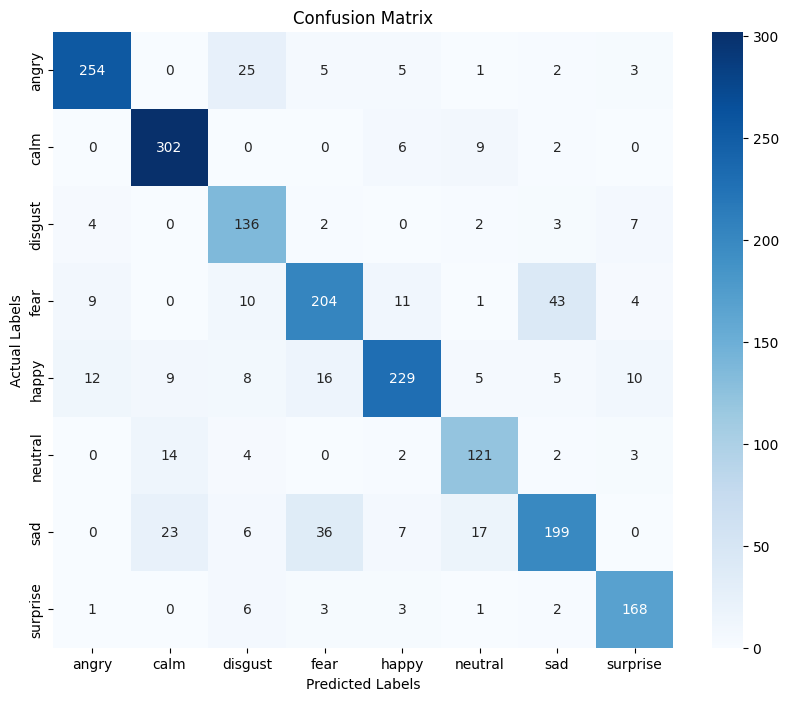

 Classification Report:
              precision    recall  f1-score     support
angry          0.907143  0.861017  0.883478   295.00000
calm           0.867816  0.946708  0.905547   319.00000
disgust        0.697436  0.883117  0.779370   154.00000
fear           0.766917  0.723404  0.744526   282.00000
happy          0.870722  0.778912  0.822262   294.00000
neutral        0.770701  0.828767  0.798680   146.00000
sad            0.771318  0.690972  0.728938   288.00000
surprise       0.861538  0.913043  0.886544   184.00000
accuracy       0.822120  0.822120  0.822120     0.82212
macro avg      0.814199  0.828243  0.818668  1962.00000
weighted avg   0.824309  0.822120  0.821042  1962.00000

 Overall Validation Accuracy: 82.21%

 F1-Score per Emotion:
angry: 88.35%
calm: 90.55%
disgust: 77.94%
fear: 74.45%
happy: 82.23%
neutral: 79.87%
sad: 72.89%
surprise: 88.65%

 Overall Weighted F1 Score: 82.10%

 Accuracy per Emotion (from Confusion Matrix):
angry: 86.10%
calm: 94.67%
disgust: 88.31%


In [14]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Inverse transform one-hot encoded labels to original label names
y_pred_labels = encoder.inverse_transform(pred_val)
y_true_labels = encoder.inverse_transform(y_val)

# Step 2: Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.categories_[0],
            yticklabels=encoder.categories_[0])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.show()

# Step 3: Classification Report
report = classification_report(y_true_labels, y_pred_labels,
                                target_names=encoder.categories_[0], output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(" Classification Report:")
print(report_df)

# Step 4: Overall Accuracy
overall_accuracy = accuracy_score(y_true_labels, y_pred_labels)
print(f"\n Overall Validation Accuracy: {overall_accuracy * 100:.2f}%")

# Step 5: F1 Score for each emotion
print("\n F1-Score per Emotion:")
for label in encoder.categories_[0]:
    f1 = report[label]['f1-score']
    print(f"{label}: {f1 * 100:.2f}%")

# Step 6: Overall Weighted F1 Score
overall_f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
print(f"\n Overall Weighted F1 Score: {overall_f1 * 100:.2f}%")


# Step 7: Accuracy per emotion from confusion matrix
print("\n Accuracy per Emotion (from Confusion Matrix):")
for i, label in enumerate(encoder.categories_[0]):
    correct = cm[i][i]
    total = cm[i].sum()
    class_accuracy = correct / total if total != 0 else 0
    print(f"{label}: {class_accuracy * 100:.2f}%")



In [15]:
import os
import tensorflow as tf
import joblib

# 1. Create a folder to save all models
os.makedirs("models", exist_ok=True)

# 2. Save trained model
model.save("models/model.h5")
print(" Model saved to models/best_model.h5")

# 3. Save fitted scaler
joblib.dump(scaler, "models/scaler.pkl")
print(" Scaler saved to models/scaler.pkl")

# 4. Save fitted label encoder
joblib.dump(encoder, "models/label_encoder.pkl")
print(" Label Encoder saved to models/label_encoder.pkl")



 Model saved to models/best_model.h5
 Scaler saved to models/scaler.pkl
 Label Encoder saved to models/label_encoder.pkl


In [16]:
import os

# Check what’s inside the working directory
print(" Files in /kaggle/working:")
print(os.listdir('/kaggle/working'))

# Check what’s inside /kaggle/working/models
model_dir = '/kaggle/working/models'
if os.path.exists(model_dir):
    print(" Files in models/:")
    print(os.listdir(model_dir))
else:
    print(" models/ folder not found!")


 Files in /kaggle/working:
['.virtual_documents', 'ravdess_features.csv', 'ravdess_combined.csv', 'models']
 Files in models/:
['scaler.pkl', 'model.h5', 'label_encoder.pkl']


In [18]:
from IPython.display import FileLink
FileLink('/kaggle/working/ser_models.zip')


/kaggle/working/ser_models.zip